# Lion optimizer

Lion optimizer, [arXiv:2302.06675 [cs.LG]](https://arxiv.org/abs/2302.06675)

Implementation https://github.com/google/automl/tree/master/lion

Algorithm:
```python
def train(weight, gradient, momentum, lr):
    update = interp(gradient, momentum, β1)
    update = sign(update)
    momentum = interp(gradient, momentum, β2)
    weight_decay = weight * λ
    update = update + weight_decay
    update = update * lr
    return update, momentum
```

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 128 # larger batch size is required for Lion
EPOCHS = 20
LEARNING_RATE = 3e-3 # learning rate should be smaller than for AdamW
WEIGHT_DECAY = 1e-3

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Optimizer

Code from https://github.com/google/automl/tree/master/lion

In [4]:
class Lion(optim.Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
        if not 0.0 <= lr:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError('Invalid beta parameter at index 0: {}'.format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError('Invalid beta parameter at index 1: {}'.format(betas[1]))
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)
    
    
    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                p.data.mul_(1 - group['lr'] * group['weight_decay'])

                grad = p.grad
                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']
                beta1, beta2 = group['betas']

                update = exp_avg * beta1 + grad * (1 - beta1)
                p.add_(torch.sign(update), alpha = -group['lr'])
                exp_avg.mul_(beta2).add_(grad, alpha = 1 - beta2)
        
        return loss

## Data

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1)
])

In [6]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [8]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

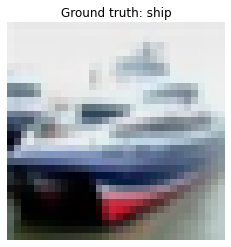

In [9]:
dataset_show_image(test_dset, 1)

## Model

Model architecture based on https://myrtle.ai/learn/how-to-train-your-resnet/ and https://github.com/tysam-code/hlb-CIFAR10

In [10]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.residual = nn.Sequential(
            ConvBlock(channels, channels, 3),
            ConvBlock(channels, channels, 3, act=False)
        )
        self.act = nn.ReLU(inplace=True)
        self.γ = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        out = x + self.γ * self.residual(x)
        out = self.act(out)
        return out

In [12]:
class DownBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            ConvBlock(in_channels, out_channels, 3),
            nn.MaxPool2d(2)
        )

In [13]:
class ResidualLayer(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            DownBlock(in_channels, out_channels),
            ResidualBlock(out_channels)
        )

In [14]:
class TemperatureScaler(nn.Module):
    def __init__(self, scaling_factor=0.1):
        super().__init__()
        self.scaler = nn.Parameter(torch.tensor(scaling_factor))

    def forward(self, x):
        return x * self.scaler

In [15]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes):
        super().__init__(
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, classes),
            TemperatureScaler()
        )

In [16]:
class Net(nn.Sequential):
    def __init__(self, classes, hidden_channels, in_channels=3):
        channels = [hidden_channels * 2**num for num in range(4)]
        super().__init__(
            ConvBlock(in_channels, hidden_channels, 3),
            ResidualLayer(channels[0], channels[1]),
            DownBlock(channels[1], channels[2]),
            ResidualLayer(channels[2], channels[3]),
            Head(channels[3], classes)
        )

In [17]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [18]:
model = Net(NUM_CLASSES, hidden_channels=64).to(DEVICE);

In [19]:
model.apply(init_linear);

In [20]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,573,133


## Training

In [21]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)

In [22]:
optimizer = Lion(model.parameters(), lr=1e-6, weight_decay=WEIGHT_DECAY)

In [23]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [24]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [25]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [26]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [27]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [28]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [29]:
history = defaultdict(list)

In [30]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

In [31]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/20 - train: loss 1.352; val: loss 1.281 accuracy 0.658
2/20 - train: loss 1.075; val: loss 1.129 accuracy 0.741
3/20 - train: loss 0.978; val: loss 1.003 accuracy 0.797
4/20 - train: loss 0.891; val: loss 0.946 accuracy 0.820
5/20 - train: loss 0.845; val: loss 0.856 accuracy 0.858
6/20 - train: loss 0.793; val: loss 0.824 accuracy 0.874
7/20 - train: loss 0.759; val: loss 0.805 accuracy 0.876
8/20 - train: loss 0.728; val: loss 0.813 accuracy 0.877
9/20 - train: loss 0.705; val: loss 0.745 accuracy 0.903
10/20 - train: loss 0.683; val: loss 0.751 accuracy 0.900
11/20 - train: loss 0.665; val: loss 0.740 accuracy 0.904
12/20 - train: loss 0.654; val: loss 0.725 accuracy 0.911
13/20 - train: loss 0.634; val: loss 0.705 accuracy 0.921
14/20 - train: loss 0.620; val: loss 0.711 accuracy 0.919
15/20 - train: loss 0.598; val: loss 0.698 accuracy 0.919
16/20 - train: loss 0.584; val: loss 0.688 accuracy 0.928
17/20 - train: loss 0.571; val: loss 0.680 accuracy 0.930
18/20 - train: loss 0.5

In [32]:
def history_plot_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

In [33]:
def history_plot(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history[key]) + 1)
    ax.plot(xs, history[key], '.-')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    plt.show()

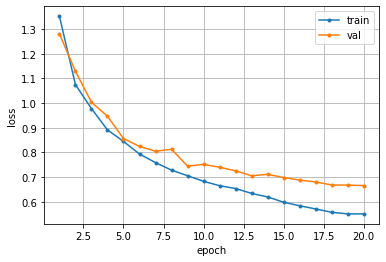

In [34]:
history_plot_train_val(history, 'loss')

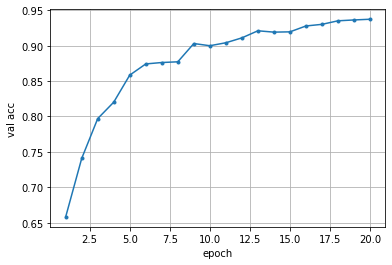

In [35]:
history_plot(history, 'val acc')